# **Transformer Study**

### Scaling Plot

In [9]:
import numpy as np

params = np.array([
    0.81e6,    
    6.04e6,    
    17.78e6,    
    59.12e6,   
    113.42e6   
])

val_losses = np.array([
    1.2311,  
    0.9779,  
    0.9295,  
    0.8977,  
    0.9093   
])

params, val_losses

(array([8.1000e+05, 6.0400e+06, 1.7780e+07, 5.9120e+07, 1.1342e+08]),
 array([1.2311, 0.9779, 0.9295, 0.8977, 0.9093]))

Fitted scaling exponent α = 0.6834661408437978


/var/folders/7x/jtprqt351tn3_hbj751vpskc0000gn/T/ipykernel_26183/587176748.py:6: RuntimeWarning: overflow encountered in power
  return a * (N ** (-alpha)) + c


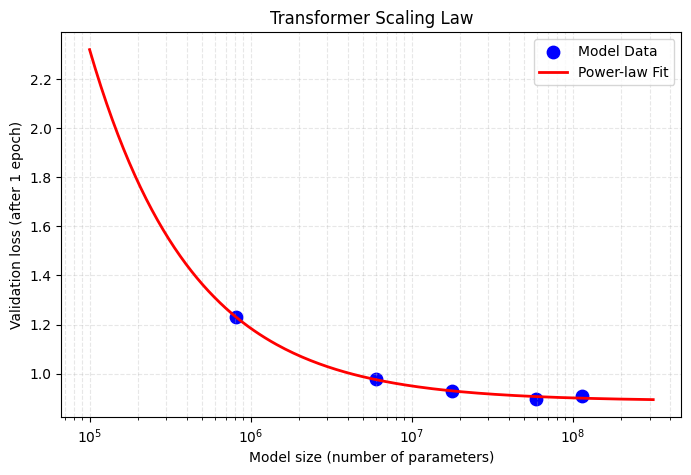

In [10]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np

def power_law(N, a, alpha, c):
    return a * (N ** (-alpha)) + c

popt, pcov = curve_fit(power_law, params, val_losses, maxfev=10000)
a, alpha, c = popt
print("Fitted scaling exponent α =", alpha)

N_fit = np.logspace(5, 8.5, 200)

plt.figure(figsize=(8,5))
plt.scatter(params, val_losses, color='blue', label="Model Data", s=80)
plt.plot(N_fit, power_law(N_fit, *popt), color='red', label="Power-law Fit", linewidth=2)

plt.xscale('log')
plt.xlabel("Model size (number of parameters)")
plt.ylabel("Validation loss (after 1 epoch)")
plt.title("Transformer Scaling Law")
plt.grid(True, which='both', linestyle='--', alpha=0.3)
plt.legend()
plt.show()

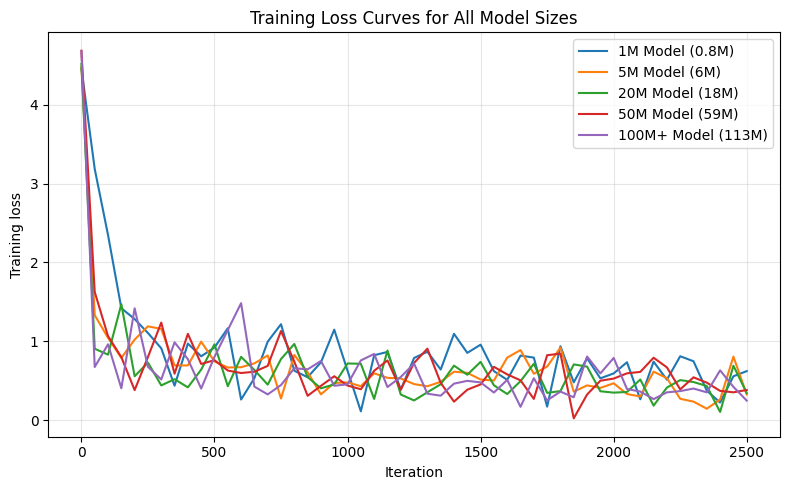

In [14]:
import re
import numpy as np
import matplotlib.pyplot as plt

log_dir = "logs"

log_files = {
    "1M Model (0.8M)":   f"{log_dir}/Model1M.txt",
    "5M Model (6M)":    f"{log_dir}/Model5M.txt",
    "20M Model (18M)":  f"{log_dir}/Model20M.txt",
    "50M Model (59M)":   f"{log_dir}/Model50M.txt",
    "100M+ Model (113M)":     f"{log_dir}/Model100M.txt",
}

def parse_log(path):
    steps = []
    iter_losses = []
    times_ms = []

    val_steps = []
    val_losses = []

    with open(path, "r") as f:
        for line in f:

            m = re.search(r"iter\s+(\d+): loss ([0-9.]+), time ([0-9.]+)ms", line)
            if m:
                steps.append(int(m.group(1)))
                iter_losses.append(float(m.group(2)))
                times_ms.append(float(m.group(3)))

            m2 = re.search(r"step\s+(\d+): train loss ([0-9.]+), val loss ([0-9.]+)", line)
            if m2:
                val_steps.append(int(m2.group(1)))
                val_losses.append(float(m2.group(3)))

    return (
        np.array(steps),
        np.array(iter_losses),
        np.array(times_ms),
        np.array(val_steps),
        np.array(val_losses),
    )

parsed_logs = {name: parse_log(path) for name, path in log_files.items()}

plt.figure(figsize=(8, 5))
for name, (steps, iter_losses, _, _, _) in parsed_logs.items():
    plt.plot(steps, iter_losses, label=name, linewidth=1.5)

plt.xlabel("Iteration")
plt.ylabel("Training loss")
plt.title("Training Loss Curves for All Model Sizes")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### **Training Loss Curves per Model**

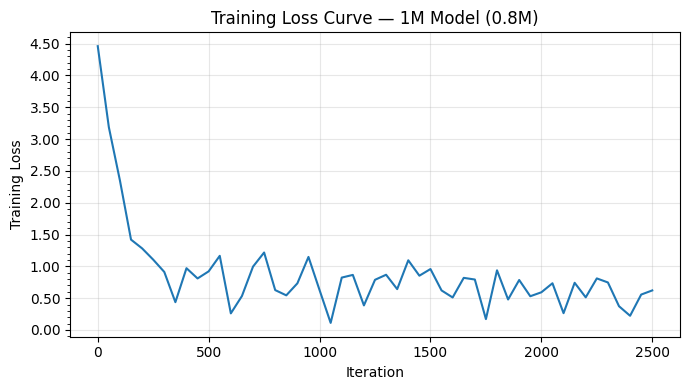

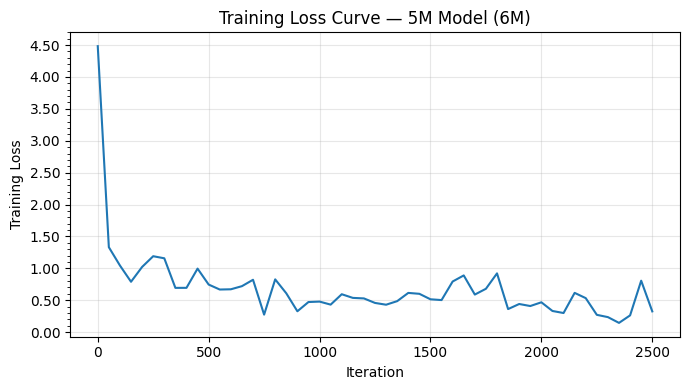

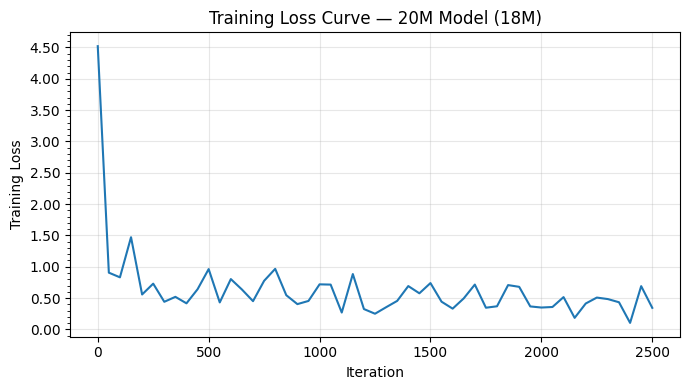

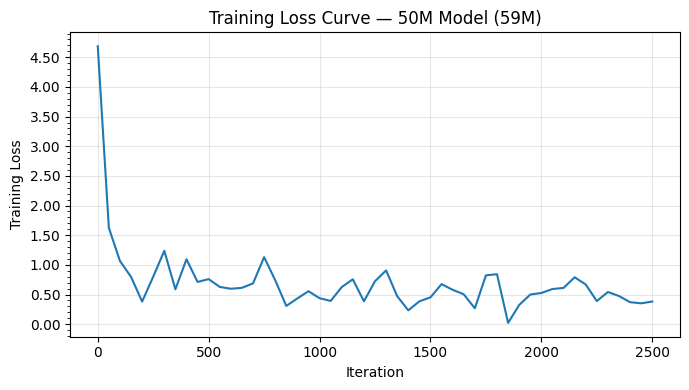

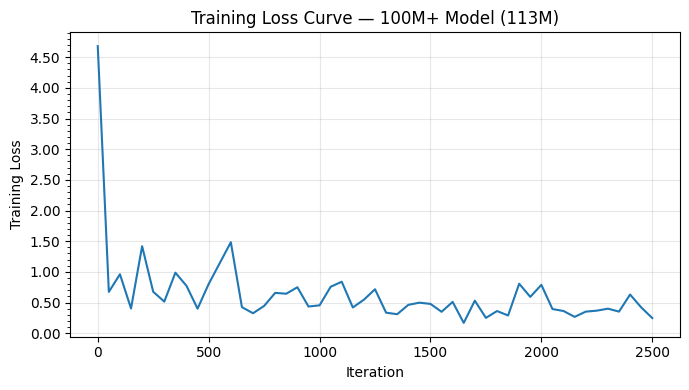

In [26]:
import matplotlib.ticker as ticker

for name, (steps, iter_losses, _, _, _) in parsed_logs.items():
    plt.figure(figsize=(7, 4))
    plt.plot(steps, iter_losses, linewidth=1.5)

    plt.title(f"Training Loss Curve — {name}")
    plt.xlabel("Iteration")
    plt.ylabel("Training Loss")

    plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.5)) 
    plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
    plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

### **Wall-Clock Time per Epoch**

In [35]:
import numpy as np
import re

def compute_model_time(times_ms):
    median_ms = np.median(times_ms)
    total_time_sec = (median_ms * 2500) / 1000.0
    return median_ms, total_time_sec

model_times = {}

for name, (steps, iter_losses, times_ms, _, _) in parsed_logs.items():
    median_ms, total_sec = compute_model_time(times_ms)
    model_times[name] = (median_ms, total_sec)

model_times


{'1M Model (0.8M)': (np.float64(69.35), np.float64(173.375)),
 '5M Model (6M)': (np.float64(212.91), np.float64(532.275)),
 '20M Model (18M)': (np.float64(459.76), np.float64(1149.4)),
 '50M Model (59M)': (np.float64(1021.57), np.float64(2553.925)),
 '100M+ Model (113M)': (np.float64(1910.31), np.float64(4775.775))}

In [36]:
for name, (median_ms, total_sec) in model_times.items():
    minutes = int(total_sec // 60)
    seconds = int(total_sec % 60)
    print(f"{name}: {minutes} min {seconds} sec")

1M Model (0.8M): 2 min 53 sec
5M Model (6M): 8 min 52 sec
20M Model (18M): 19 min 9 sec
50M Model (59M): 42 min 33 sec
100M+ Model (113M): 79 min 35 sec


### **Table of Model Architectures**

| Model  | Parameters | Layers | Heads | Embedding Dimension | Validation Loss | Training Time |
| ------ | ---------- | ------ | ----- | ------------- | --------------- | ------------------------ |
| Tiny   | 0.81M      | 4      | 4     | 128           | 1.2311          | 00:02:53                 |
| Small  | 6.04M      | 6      | 6     | 288           | 0.9779          | 00:08:52                 |
| Medium | 17.78M     | 10     | 8     | 384           | 0.9295          | 00:19:10                 |
| Large  | 59.12M     | 12     | 8     | 640           | 0.8977          | 00:42:34                 |
| XL     | 113.42M    | 16     | 8     | 768           | 0.9093          | 01:19:36                 |

#### Analysis: Loss vs Model Size

Across the five model sizes trained (0.81M → 113M parameters), we observe a clear but non-linear improvement in validation loss as model capacity increases. Moving from 0.81M to 6.04M parameters yields the largest gain, with loss dropping from 1.2311 → 0.9779, indicating that small models are heavily capacity-limited and benefit strongly from increased width and depth. As we scale further to 17.78M and 59.12M parameters, the validation loss continues to improve, reaching a minimum of 0.8977, consistent with power-law behavior where returns diminish gradually with size. However, scaling to the largest model (113M parameters) does not yield additional improvements; instead, the loss rises slightly to 0.9093.

This deviation from a perfect power-law trend suggests under-training at the largest scale: the fixed compute budget (2500 steps) is insufficient for larger models to reach their optimal loss. In other words, the 113M model is under-optimized, not inherently worse. Overall, the results show a strong negative correlation between model size and validation loss up to ~60M parameters, followed by a small reversal caused by insufficient training time rather than scaling failure.